# <center> </center>
# <center> 10. Multivariate Volatility
## <center> ECO374

Load Python packages

In [1]:
pth_packages = ['yfinance']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
import matplotlib.dates as mdates, statsmodels.api as sm
from itertools import combinations

# 1. Data
Specify portfolio assets, [tickers](https://finance.yahoo.com/lookup/), and their colors

In [2]:
names = ["Pfizer", "AstraZeneca", "Johnson&Johnson", "Merck"]

tickers = ["PFE", "AZN", "JNJ", "MRK"]

color_palette = ["#4682B4", "#FF8C00", "#9ACD32", "#00CED1"]

Obtain data automatically and extract Close prices

In [3]:
data = yf.download(tickers, start="2022-06-01", end='2025-03-01', progress=False, auto_adjust=False)
prices = data["Close"]
returns = np.log(prices / prices.shift(1)).dropna()*100 # in % terms

# 2. Plots

Plot asset prices

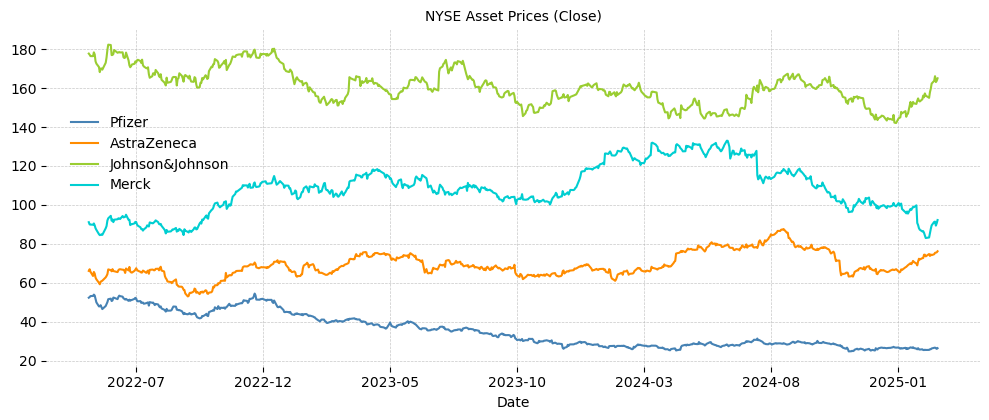

In [4]:
prices_df = prices.reset_index()
prices_melted = prices_df.melt(id_vars="Date", var_name="Ticker", value_name="Price")

prices_melted["Name"] = pd.Categorical(prices_melted["Ticker"], categories=tickers, ordered=True)
prices_melted["Name"] = prices_melted["Name"].map(dict(zip(tickers, names)))
colors = dict(zip(names, color_palette))

plt.figure(figsize=(10, 4.3))

for name in names:
    data = prices_melted[prices_melted["Name"] == name]
    plt.plot(data["Date"], data["Price"], label=name, color=colors[name])

plt.title("NYSE Asset Prices (Close)", fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylabel("", fontsize=10)
plt.legend(loc=(0.02, 0.5), frameon=False, fontsize=10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.box(False)

plt.tight_layout()
plt.show()

Plot asset returns

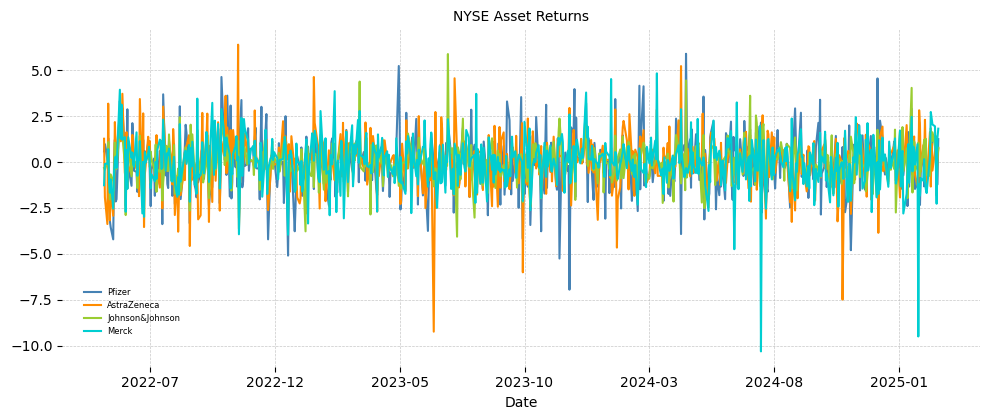

In [5]:
returns_df = returns.reset_index()
returns_melted = returns_df.melt(id_vars="Date", var_name="Ticker", value_name="Return")

returns_melted["Name"] = pd.Categorical(returns_melted["Ticker"], categories=tickers, ordered=True)
returns_melted["Name"] = returns_melted["Name"].map(dict(zip(tickers, names)))
colors = dict(zip(names, color_palette))

plt.figure(figsize=(10, 4.3))

for name in names:
    data = returns_melted[returns_melted["Name"] == name]
    plt.plot(data["Date"], data["Return"], label=name, color=colors[name])

plt.title("NYSE Asset Returns", fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylabel("", fontsize=10)
plt.legend(loc=(0.02, 0.08), frameon=False, fontsize=6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.box(False)

plt.tight_layout()
plt.show()

Plot asset returns squared (variances)

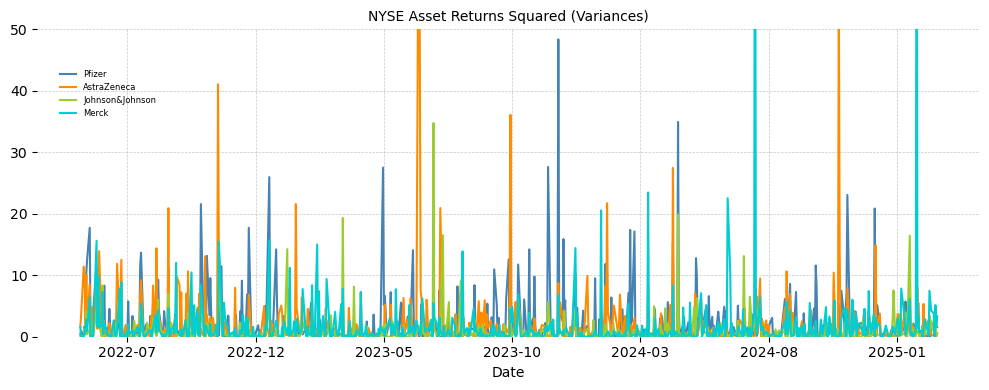

In [6]:
vars = returns**2
vars_df = vars.reset_index()
vars_melted = vars_df.melt(id_vars="Date", var_name="Ticker", value_name="Variance")
vars_melted["Name"] = pd.Categorical(vars_melted["Ticker"], categories=tickers, ordered=True)
vars_melted["Name"] = vars_melted["Name"].map(dict(zip(tickers, names)))
colors = dict(zip(names, color_palette))

plt.figure(figsize=(10, 4))

for name in names:
    data = vars_melted[vars_melted["Name"] == name]
    plt.plot(data["Date"], data["Variance"], label=name, color=colors[name])

plt.title("NYSE Asset Returns Squared (Variances)", fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylabel("", fontsize=10)
plt.legend(loc=(0.02, 0.7), frameon=False, fontsize=6)
plt.ylim(0, 50)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.box(False)

plt.tight_layout()
plt.show()

Plot pairwise scatterplots for assessing unconditional correlation

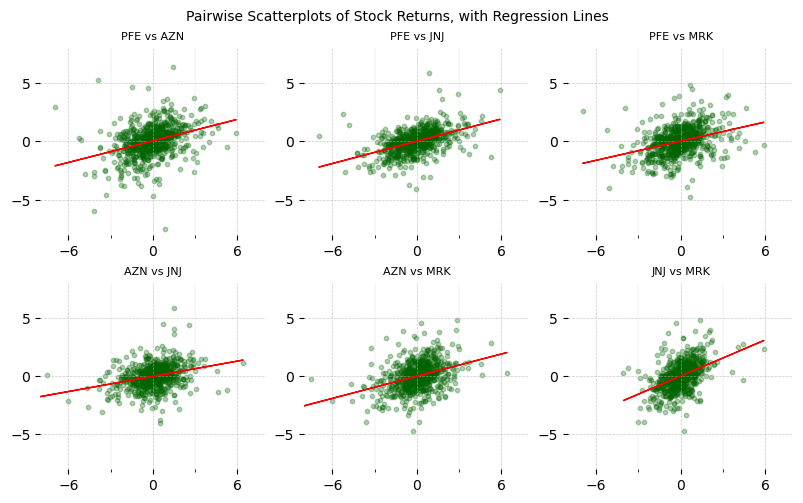

In [7]:
stock_combinations = list(combinations(tickers, 2))
pairwise_returns = []

for stock1, stock2 in stock_combinations:
    pair_data = pd.DataFrame({
        "Stock1": returns[stock1],
        "Stock2": returns[stock2],
        "StockPair": f"{stock1} vs {stock2}"
    })
    pairwise_returns.append(pair_data)

pairwise_returns = pd.concat(pairwise_returns, ignore_index=True)
fig, axes = plt.subplots(
    nrows=int(np.ceil(len(stock_combinations)/3)),
    ncols=3, figsize=(8, 5), constrained_layout=True
)

axes = axes.flatten()
for i, (stock1, stock2) in enumerate(stock_combinations):
    ax = axes[i]
    data = pairwise_returns[pairwise_returns["StockPair"] == f"{stock1} vs {stock2}"]

    ax.scatter(data["Stock1"], data["Stock2"], color="darkgreen", alpha=0.3, s=10)

    X = sm.add_constant(data["Stock1"])
    model = sm.OLS(data["Stock2"], X).fit() # Add regression line
    ax.plot(data["Stock1"], model.predict(X), color="red", linewidth=1)

    ax.set_title(f"{stock1} vs {stock2}", fontsize=8)
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
    ax.xaxis.set_minor_locator(plt.MaxNLocator(nbins=6))
    ax.grid(which='minor', color='lightgrey', linewidth=0.2)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    for spine in ax.spines.values():
      spine.set_visible(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Pairwise Scatterplots of Stock Returns, with Regression Lines", fontsize=10)
fig.supxlabel("")
fig.supylabel("")
plt.show()

Mean (unconditional) Correlation matrix of returns

In [8]:
print(returns.corr())

Ticker       AZN       JNJ       MRK       PFE
Ticker                                        
AZN     1.000000  0.302092  0.339365  0.325130
JNJ     0.302092  1.000000  0.398656  0.466456
MRK     0.339365  0.398656  1.000000  0.308665
PFE     0.325130  0.466456  0.308665  1.000000


Mean (unconditional) Covariance matrix of returns

In [9]:
print(returns.cov())

Ticker       AZN       JNJ       MRK       PFE
Ticker                                        
AZN     2.014938  0.439056  0.640179  0.690449
JNJ     0.439056  1.048333  0.542440  0.714503
MRK     0.640179  0.542440  1.766069  0.613669
PFE     0.690449  0.714503  0.613669  2.238134
